<a href="https://colab.research.google.com/github/Yanikko/progetto-AI-2/blob/main/02_preprocessing_HARTH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HARTH — Preprocessing & Feature Engineering (02_preprocessing.ipynb)

Obiettivo:
- caricare HARTH (da UCI)
- pulire colonne spurie (`index`, `Unnamed: 0` se presenti)
- creare **finestre temporali** (windowing) per soggetto
- estrarre **feature tabellari** (time-domain) per modelli classici
- salvare un dataset compatto: `X_features`, `y`, `groups(subject)`

Scelte motivate dall’EDA:
- dataset molto grande → evitare training su segnali grezzi
- classi sbilanciate → tenere traccia per metriche/strategie
- distribuzione per soggetto non uniforme → mantenere `groups` per split per soggetto (lo faremo nel notebook modelli)


In [ ]:
import os, re, math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 80)
pd.set_option("display.width", 140)


## 1) Download & unpack (se non già fatto)

In [ ]:
import subprocess

DATA_DIR = Path("data_raw/harth")
DATA_DIR.mkdir(parents=True, exist_ok=True)

zip_path = DATA_DIR / "harth.zip"
url = "https://archive.ics.uci.edu/static/public/779/harth.zip"

if not zip_path.exists():
    subprocess.run(["bash", "-lc", f"wget -O '{zip_path}' '{url}'"], check=True)

marker = DATA_DIR / ".unzipped"
if not marker.exists():
    subprocess.run(["bash", "-lc", f"unzip -q '{zip_path}' -d '{DATA_DIR}'"], check=True)
    marker.write_text("ok")

csv_files = sorted([p for p in DATA_DIR.rglob("*.csv")])
print("CSV files:", len(csv_files))
print("Esempi:", [str(p.relative_to(DATA_DIR)) for p in csv_files[:5]])


CSV files: 22
Esempi: ['harth/S006.csv', 'harth/S008.csv', 'harth/S009.csv', 'harth/S010.csv', 'harth/S012.csv']


## 2) Lettura robusta + inferenza soggetto dal filename

In [ ]:
def read_csv_safe(path: Path) -> pd.DataFrame:
    return pd.read_csv(path)

def infer_subject_from_filename(p: Path) -> int:
    m = re.search(r"(?:sub(?:ject)?|s|p)[_\- ]*(\d+)", p.stem, flags=re.IGNORECASE)
    if not m:
        raise ValueError(f"Cannot infer subject from filename: {p.name}")
    return int(m.group(1))

p0 = csv_files[0]
df0 = read_csv_safe(p0)
sub0 = infer_subject_from_filename(p0)
print("File:", p0.name, "subject:", sub0, "shape:", df0.shape)
display(df0.head())
print("Columns:", list(df0.columns))


File: S006.csv subject: 6 shape: (408709, 8)


,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
0,2019-01-12 00:00:00.000,-0.760242,0.299570,0.468570,-5.092732,-0.298644,0.709439,6
1,2019-01-12 00:00:00.010,-0.530138,0.281880,0.319987,0.900547,0.286944,0.340309,6
2,2019-01-12 00:00:00.020,-1.170922,0.186353,-0.167010,-0.035442,-0.078423,-0.515212,6
3,2019-01-12 00:00:00.030,-0.648772,0.016579,-0.054284,-1.554248,-0.950978,-0.221140,6
4,2019-01-12 00:00:00.040,-0.355071,-0.051831,-0.113419,-0.547471,0.140903,-0.653782,6


Columns: ['timestamp', 'back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z', 'label']


## 3) Pulizia colonne e parsing timestamp

In [ ]:
SENSOR_COLS = ["back_x", "back_y", "back_z", "thigh_x", "thigh_y", "thigh_z"]
LABEL_COL = "label"
TIME_COL = "timestamp"

def clean_df(df: pd.DataFrame, subject_id: int, source_file: str) -> pd.DataFrame:
    df = df.drop(columns=["index", "Unnamed: 0"], errors="ignore").copy()
    df["subject"] = subject_id
    df["source_file"] = source_file
    if df[TIME_COL].dtype == "object":
        df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors="coerce")
    df = df.sort_values(TIME_COL).reset_index(drop=True)
    return df

df0c = clean_df(df0, sub0, str(p0.relative_to(DATA_DIR)))
display(df0c.head())
print(df0c.dtypes)


,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label,subject,source_file
0,2019-01-12 00:00:00.000,-0.760242,0.299570,0.468570,-5.092732,-0.298644,0.709439,6,6,harth/S006.csv
1,2019-01-12 00:00:00.010,-0.530138,0.281880,0.319987,0.900547,0.286944,0.340309,6,6,harth/S006.csv
2,2019-01-12 00:00:00.020,-1.170922,0.186353,-0.167010,-0.035442,-0.078423,-0.515212,6,6,harth/S006.csv
3,2019-01-12 00:00:00.030,-0.648772,0.016579,-0.054284,-1.554248,-0.950978,-0.221140,6,6,harth/S006.csv
4,2019-01-12 00:00:00.040,-0.355071,-0.051831,-0.113419,-0.547471,0.140903,-0.653782,6,6,harth/S006.csv


timestamp      datetime64[ns]
back_x                float64
back_y                float64
back_z                float64
thigh_x               float64
thigh_y               float64
thigh_z               float64
label                   int64
subject                 int64
source_file            object
dtype: object


## 4) Windowing: parametri consigliati

- Frequenza ~50Hz (EDA)  
- Proposta: **3s** (150 campioni) e **overlap 50%** (step 75)

Gestione transizioni:
- label finestra = **maggioranza**
- opzionale: scartare finestre “sporche” se la maggioranza è < `purity_threshold`


In [ ]:
FS = 50
WINDOW_SEC = 3.0
WINDOW_SIZE = int(WINDOW_SEC * FS)  # 150
STEP = WINDOW_SIZE // 2            # 75
PURITY_THRESHOLD = 0.8

WINDOW_SIZE, STEP


(150, 75)

## 5) Feature engineering (time-domain)

In [ ]:
def magnitude(x, y, z):
    return np.sqrt(x*x + y*y + z*z)

def compute_features(window: np.ndarray, prefix: str) -> dict:
    feats = {}
    for j in range(window.shape[1]):
        v = window[:, j]
        feats[f"{prefix}{j}_mean"] = float(np.mean(v))
        feats[f"{prefix}{j}_std"]  = float(np.std(v))
        feats[f"{prefix}{j}_min"]  = float(np.min(v))
        feats[f"{prefix}{j}_max"]  = float(np.max(v))
        feats[f"{prefix}{j}_energy"] = float(np.mean(v*v))
    return feats

def featurize_segment(seg: pd.DataFrame) -> dict:
    back = seg[["back_x", "back_y", "back_z"]].to_numpy(dtype=np.float32)
    thigh = seg[["thigh_x", "thigh_y", "thigh_z"]].to_numpy(dtype=np.float32)

    feats = {}
    feats.update(compute_features(back,  "back_"))
    feats.update(compute_features(thigh, "thigh_"))

    back_mag = magnitude(back[:,0], back[:,1], back[:,2]).reshape(-1,1)
    thigh_mag = magnitude(thigh[:,0], thigh[:,1], thigh[:,2]).reshape(-1,1)
    feats.update(compute_features(back_mag,  "back_mag_"))
    feats.update(compute_features(thigh_mag, "thigh_mag_"))
    return feats


## 6) Costruzione dataset finestre → feature (streaming per file)

In [ ]:
from collections import Counter

def majority_label(y_window: np.ndarray):
    c = Counter(y_window.tolist())
    lab, cnt = c.most_common(1)[0]
    purity = cnt / len(y_window)
    return lab, purity

def windows_to_features(df: pd.DataFrame,
                        window_size: int = WINDOW_SIZE,
                        step: int = STEP,
                        purity_threshold: float = PURITY_THRESHOLD):
    X_rows, y_rows, g_rows, meta_rows = [], [], [], []
    n = len(df)
    for start in range(0, n - window_size + 1, step):
        seg = df.iloc[start:start+window_size]
        lab, purity = majority_label(seg[LABEL_COL].to_numpy())
        if purity < purity_threshold:
            continue
        X_rows.append(featurize_segment(seg))
        y_rows.append(lab)
        g_rows.append(int(seg["subject"].iloc[0]))
        meta_rows.append({
            "subject": int(seg["subject"].iloc[0]),
            "source_file": seg["source_file"].iloc[0],
            "t_start": seg[TIME_COL].iloc[0],
            "t_end": seg[TIME_COL].iloc[-1],
            "purity": purity
        })
    return X_rows, y_rows, g_rows, meta_rows

X_tmp, y_tmp, g_tmp, meta_tmp = windows_to_features(df0c)
print("Windows kept:", len(y_tmp))
print("Unique labels:", len(set(y_tmp)))
display(pd.Series(y_tmp).value_counts().head(10))


Windows kept: 5033
Unique labels: 10


,count
7,3366
6,697
13,318
1,232
8,172
130,138
3,39
14,38
5,17
4,16


## 7) Esecuzione su tutti i soggetti (può richiedere tempo)

In [ ]:
MAX_SUBJECTS = None  # es. 5 per test; None = tutti

X_all, y_all, g_all, meta_all = [], [], [], []
files = csv_files if MAX_SUBJECTS is None else csv_files[:MAX_SUBJECTS]

for p in files:
    sid = infer_subject_from_filename(p)
    dfi = clean_df(read_csv_safe(p), sid, str(p.relative_to(DATA_DIR)))
    missing_cols = [c for c in SENSOR_COLS + [LABEL_COL, TIME_COL] if c not in dfi.columns]
    if missing_cols:
        raise ValueError(f"{p.name}: missing columns {missing_cols}")
    X_rows, y_rows, g_rows, meta_rows = windows_to_features(dfi)
    X_all.extend(X_rows)
    y_all.extend(y_rows)
    g_all.extend(g_rows)
    meta_all.extend(meta_rows)

print("Feature rows:", len(y_all))
print("N subjects:", len(set(g_all)))
print("Class distribution (top):")
display(pd.Series(y_all).value_counts().head(15))


Feature rows: 79467
N subjects: 22
Class distribution (top):


,count
7,38550
1,14331
6,8084
8,5677
13,5091
2,3796
3,1277
4,818
14,667
5,614


## 8) Salvataggio (Parquet)

In [ ]:
OUT_DIR = Path("data/processed")
OUT_DIR.mkdir(parents=True, exist_ok=True)

X_df = pd.DataFrame(X_all)
y_ser = pd.Series(y_all, name="label")
g_ser = pd.Series(g_all, name="subject")
meta_df = pd.DataFrame(meta_all)

print("X shape:", X_df.shape, "y:", y_ser.shape, "groups:", g_ser.shape)
display(X_df.head())

X_df.to_parquet(OUT_DIR / "X_features.parquet", index=False)
y_ser.to_frame().to_parquet(OUT_DIR / "y_labels.parquet", index=False)
g_ser.to_frame().to_parquet(OUT_DIR / "groups_subject.parquet", index=False)
meta_df.to_parquet(OUT_DIR / "windows_meta.parquet", index=False)

print("Saved to:", OUT_DIR.resolve())


X shape: (79467, 40) y: (79467,) groups: (79467,)


,back_0_mean,back_0_std,back_0_min,back_0_max,back_0_energy,back_1_mean,back_1_std,back_1_min,back_1_max,back_1_energy,back_2_mean,back_2_std,back_2_min,back_2_max,back_2_energy,thigh_0_mean,thigh_0_std,thigh_0_min,thigh_0_max,thigh_0_energy,thigh_1_mean,thigh_1_std,thigh_1_min,thigh_1_max,thigh_1_energy,thigh_2_mean,thigh_2_std,thigh_2_min,thigh_2_max,thigh_2_energy,back_mag_0_mean,back_mag_0_std,back_mag_0_min,back_mag_0_max,back_mag_0_energy,thigh_mag_0_mean,thigh_mag_0_std,thigh_mag_0_min,thigh_mag_0_max,thigh_mag_0_energy
0,-0.996587,0.038474,-1.272421,-0.952415,0.994665,0.071433,0.040270,-0.028849,0.467094,0.006724,0.066707,0.029406,-0.086133,0.141577,0.005315,-0.960233,0.045125,-1.300614,-0.870048,0.924083,0.073154,0.035164,0.030090,0.302179,0.006588,-0.303720,0.035148,-0.407529,-0.092001,0.093481,1.002417,0.043173,0.953865,1.362819,1.006704,1.011174,0.040989,0.965426,1.308329,1.024152
1,-0.983860,0.065738,-1.413744,-0.802925,0.972301,0.121802,0.103753,-0.192840,0.511083,0.025600,0.089364,0.046876,-0.085015,0.293643,0.010183,-0.993889,0.092250,-1.474092,-0.750604,0.996325,0.080636,0.126504,-0.303226,0.673558,0.022505,-0.221810,0.164835,-0.843538,0.553840,0.076370,1.001768,0.067417,0.858585,1.531699,1.008085,1.040724,0.109971,0.832054,1.500345,1.095201
2,-0.989083,0.006127,-1.003145,-0.980028,0.978323,0.101997,0.014883,0.064781,0.144725,0.010625,0.053265,0.007762,0.033504,0.081632,0.002897,-0.972996,0.004334,-0.989530,-0.955061,0.946740,0.019738,0.014870,-0.026735,0.056641,0.000611,-0.239936,0.012222,-0.275305,-0.207471,0.057719,0.995898,0.005653,0.985843,1.008072,0.991846,1.002521,0.004557,0.986028,1.016500,1.005070
3,-0.986296,0.004684,-1.003145,-0.980028,0.972802,0.109627,0.013354,0.078106,0.144725,0.012196,0.060995,0.009467,0.036793,0.081632,0.003810,-0.973578,0.003340,-0.989530,-0.957548,0.947866,0.013937,0.013086,-0.026735,0.056641,0.000365,-0.231581,0.009787,-0.258725,-0.207471,0.053726,0.994380,0.004229,0.986210,1.010653,0.988809,1.000971,0.003629,0.989470,1.016500,1.001957
4,-0.985436,0.003873,-1.001719,-0.980081,0.971100,0.116225,0.007092,0.101993,0.134631,0.013559,0.065270,0.006989,0.051615,0.086576,0.004309,-0.973808,0.002957,-0.989648,-0.960240,0.948310,0.012621,0.009145,-0.013471,0.027624,0.000243,-0.230910,0.007682,-0.255664,-0.209650,0.053379,0.994460,0.004010,0.988402,1.010903,0.988967,1.000960,0.003245,0.990293,1.018768,1.001932


Saved to: /content/data/processed


## 9) Controlli rapidi

,n_windows
subject,
6,5033
8,5088
9,1940
10,4123
12,4895
13,4375
14,4350
15,5133
16,4373


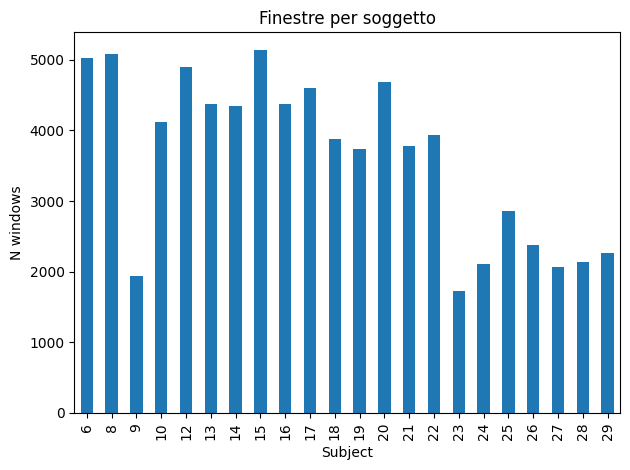

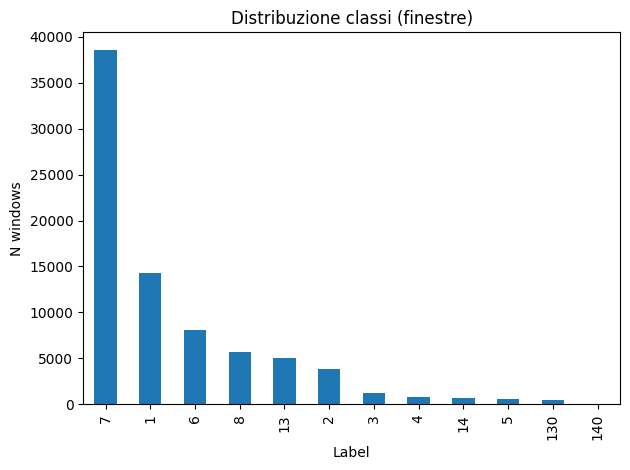

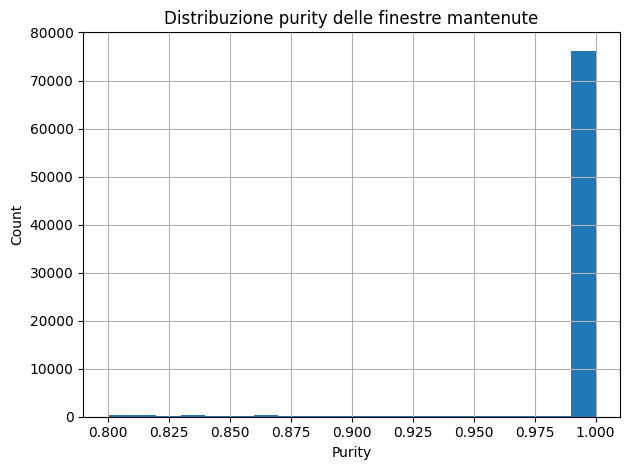

In [ ]:
subj_counts = g_ser.value_counts().sort_index()
display(subj_counts.to_frame("n_windows").head(30))

plt.figure()
subj_counts.plot(kind="bar")
plt.title("Finestre per soggetto")
plt.xlabel("Subject")
plt.ylabel("N windows")
plt.tight_layout()
plt.show()

class_counts = y_ser.value_counts()
plt.figure()
class_counts.head(20).plot(kind="bar")
plt.title("Distribuzione classi (finestre)")
plt.xlabel("Label")
plt.ylabel("N windows")
plt.tight_layout()
plt.show()

if len(meta_df) > 0 and "purity" in meta_df.columns:
    plt.figure()
    meta_df["purity"].hist(bins=20)
    plt.title("Distribuzione purity delle finestre mantenute")
    plt.xlabel("Purity")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
